# **<center><font style="color:rgb(100,109,254)">Age Classification Using Transfer Learning-VGG16</font> </center>**

## **<font style="color:rgb(134,19,348)"> Steps </font>**

- **`Step 1:` Visualize the Dataset**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Implement the Tranfer Learning Approach**

    - **`a)` Construct the Model**
    
    - **`b)` Compile & Train the Model**
    
    - **`c)` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 4:` Test the model**


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [16]:
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping

import visualkeras
from PIL import ImageFont




I will set a seed to get consistent results in every execution

In [17]:
seed_constant = 27
random.seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Dataset**

I am using [UTKFace - Large Scale Face Dataset](https://susanqq.github.io/UTKFace/), with long age span(range from 0-116). The Dataset contains over 20,000 face images with annotations of age, gender, and ethnicity:

The labels of each face image is embedded in the file name, formated like **`[age]_[gender]_[race]_[date&time].jpg`**

*   **`[age]`** is an integer from 0 to 116, indicating the age

*   **`[gender]`** is either 0 (male) or 1 (female)

*   **`[race]`** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

*   **`[date&time]`**is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

For visualization, I will pick `5` random images from the dataset with their associated labels written.

In [18]:
#path of dataset
img_dir="/Users/kumara/Desktop/machine learning /deep learning projects/supervised/Age detecting flask app using CNN/new/new_imageset"

#all image names
all_img_names=os.listdir(img_dir)



In [19]:
len(all_img_names)

5148

[3931, 2270, 2342, 1608, 605]


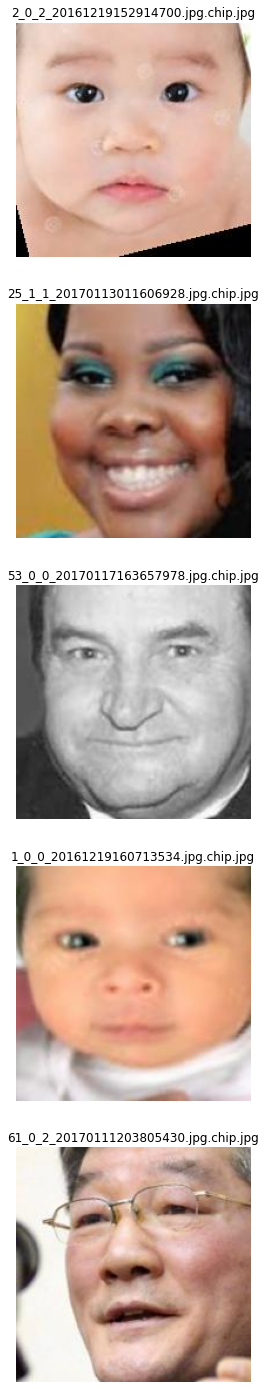

In [20]:
# Create a Matplotlib figure.
plt.figure(figsize=(25,25))

# Generate a list of 5 random values. The values should be less than number of images in dataset. 
random_range = random.sample(range(len(all_img_names)), 5)


#Iterate through random values
for counter, random_index in enumerate(random_range, 1):
    
    #Name of the selected image
    img_name=all_img_names[random_index]
    
    #Path of the selected image
    img_path=os.path.join(img_dir,img_name)
    
    #Read the selected image in BGR format
    bgr_img=cv2.imread(img_path)
    
    #Convert it into RGB format
    rgb_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
    
    
    #Display the selected image
    plt.subplot(5, 1, counter)
    plt.imshow(rgb_img)
    plt.title(img_name)
    plt.axis('off')
    

   

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

I will perform some preprocessing on the dataset. First, I will read the image and resize it to 224x224(
`VGG16` requires 224x224 color images).Also,I will normalize the data to range `[0-1]` by dividing the pixel values with `255`.

Our model classifies ages into 5 groups (`0-24`, `25-49`, `50-74`, `75-99`, and `100-124`). I will perform integer division by 25 to categorize the images into above 5 classes.



In [5]:
img_height=224
img_width=224


### **<font style="color:rgb(134,19,348)">Create a Function to Resize & Normalize Images</font>**

I will create a function **`image_preprocessing`** that will resize and normalize the image whose path is passed to it as an argument.

In [70]:
def image_preprocessing(img_path):
    
    
    #Read the image
    img=cv2.imread(img_path)
    
    #Resize the image 
    resized_img=cv2.resize(img,(img_height,img_width))
    
    #Normalize the image
    normalized_img=resized_img/255
    
    return normalized_img

### **<font style="color:rgb(134,19,348)">Create a Function for label extraction</font>**

Now I will create a function **`label_extraction()`** that will extract age from image name and return the class index by performing integer division (by 25).

**`Age class`  `Class index`**
- **`0-24`   --> 0**
- **`25-49`  --> 1**
- **`50-74`  --> 2**
- **`75-99`  --> 3**
- **`100-124`--> 4**




In [7]:
def label_extraction(img_name):
    
    '''
    This function will extract age from image name and return the class index by performing integer division (by 25).
    Args:
        img_name: The name of the image.
    Returns:
        class_index: An integer representing the age class.
    '''
    #Extract age 
    age=int(img_name.split("_")[0])
    
    #Class index dividing by 25
    class_index=age//25
    
    
    return class_index

### **<font style="color:rgb(134,19,348)">Create a Function for feature and label Creation</font>**

I will create a function **`create_dataset()`** that will iterate through all the images specified in the **`all_image_names`**  and will call the function  **`image_preprocessing()`** on every image and return the preprocessed images (**`features`**).
**`create_dataset()`** function also returns class index ( **`labels`**) by calling the function **`label_extraction()`**.

In [8]:
def create_dataset():
    
    
    '''
    This function will create the dataset.
    Returns:
        features:  A list containing the preprocessed images.
        labels:    A list containing the class indexes.
    '''
    
    
    #Declare empty lists to store features and labels.
    
    features=[]
    labels=[]
    
    for img_name in all_img_names:
        
        #DS_Store mac system file is created to store metadata of folder.
        if img_name!='.DS_Store':
            
            #Path of the image
            img_path=os.path.join(img_dir,img_name)
            
            #Get the preprocessed image
            preprocessed_img=image_preprocessing(img_path)
            
            #Get the class index
            class_index=label_extraction(img_name)
            
            #Append data into appropriate lists
            features.append(preprocessed_img)
            labels.append(class_index)
        
            
    #Convert lists to numpy arrays
    features=np.asarray(features)
    labels=np.asarray(labels)
    
    return features,labels

In [9]:
#Create the dataset
features,labels=create_dataset()

I will convert `labels` (class indexes) into one-hot encoded vectors.

In [10]:
encoded_labels=np_utils.to_categorical(labels)

### **<font style="color:rgb(134,19,348)">Split the Data into Train and Test Set</font>**

I will split our data to create training and testing sets. I will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [11]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,
                                                                            test_size = 0.1, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 3: Implement the Transfer Learning Approach**
    


### **<font style="color:rgb(134,19,348)">`a)` Construct the Model**

In [14]:
#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers 
for layer in vgg.layers:
  layer.trainable = False

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### **<font style="color:rgb(134,19,348)"> Visualize Model‘s Structure**

I use `Visualkeras` to visualize the model 

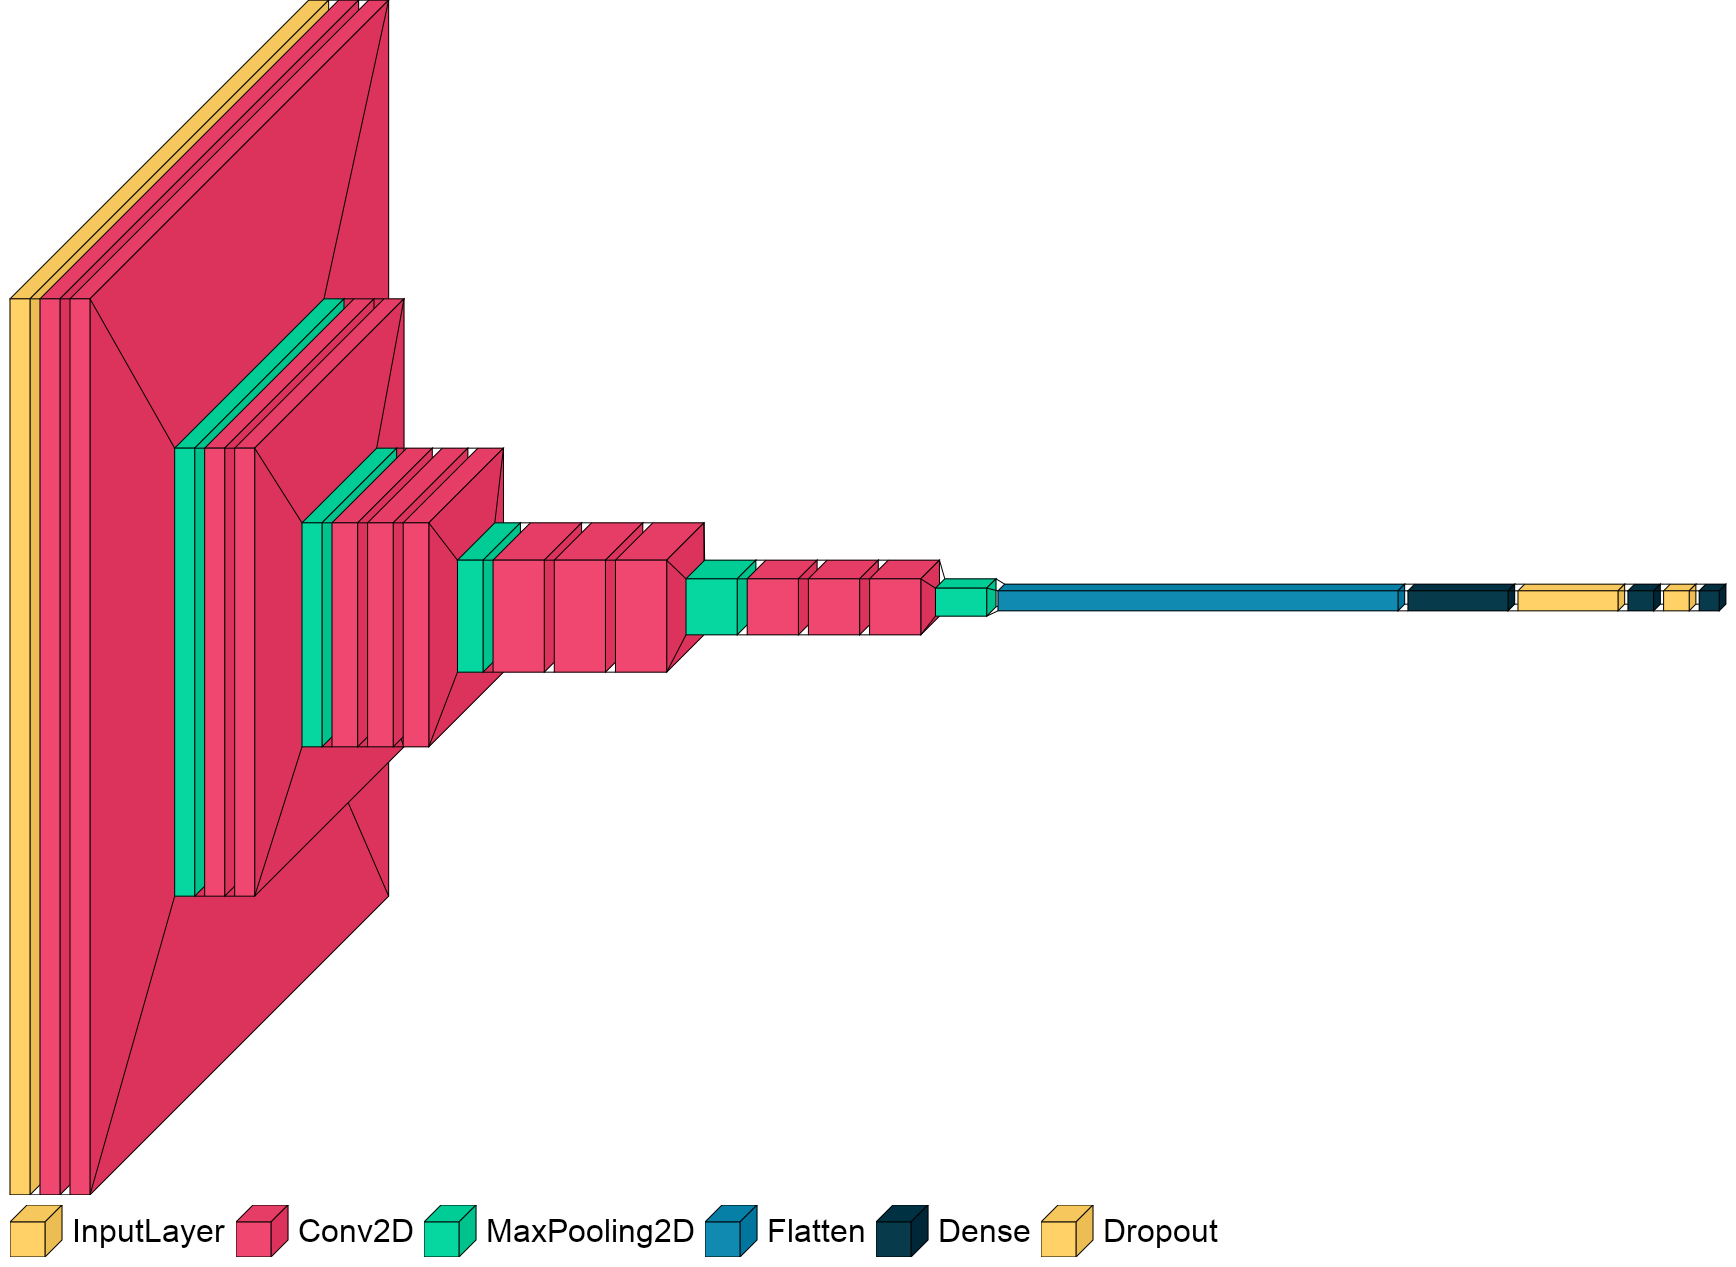

In [15]:
#selected font
font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 32)
visualkeras.layered_view(model, legend=True, font=font) 

### **<font style="color:rgb(134,19,348)">`b)` Compile & Train the Model</font>**


adam optimizer decay

ReduceLROnPlateau
learning rate schedule

In [41]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs = 50, 
                    shuffle = True, validation_split = 0.1, 
                    callbacks = callbacks_list )

2022-07-24 16:16:26.439839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-24 16:16:26.469807: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-07-24 16:16:33.869369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 4.1247 - accuracy: 0.4629

2022-07-24 16:17:59.309602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 102s 700ms/step - loss: 4.1142 - accuracy: 0.4634 - val_loss: 1.5060 - val_accuracy: 0.7004

Epoch 00001: val_accuracy improved from -inf to 0.70043, saving model to weights.best.hdf5
Epoch 2/50
131/131 [==============================] - 269s 2s/step - loss: 1.5480 - accuracy: 0.6196 - val_loss: 1.1909 - val_accuracy: 0.7134

Epoch 00002: val_accuracy improved from 0.70043 to 0.71336, saving model to weights.best.hdf5
Epoch 3/50
131/131 [==============================] - 92s 704ms/step - loss: 1.2418 - accuracy: 0.6590 - val_loss: 1.1369 - val_accuracy: 0.6853

Epoch 00003: val_accuracy did not improve from 0.71336
Epoch 4/50
131/131 [==============================] - 97s 739ms/step - loss: 1.1282 - accuracy: 0.6575 - val_loss: 0.9498 - val_accuracy: 0.7522

Epoch 00004: val_accuracy improved from 0.71336 to 0.75216, saving model to weights.best.hdf5
Epoch 5/50
131/131 [==============================] - 99s 753ms/step - loss: 0.9837 - accuracy

In [43]:
# load weights of model with best validation accuracy
model.load_weights("weights.best.hdf5")

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, I will evaluate the model on the test set.

In [42]:
model_evaluation_history_base = model.evaluate(features_test, labels_test)

17/17 [==============================] - 10s 582ms/step - loss: 0.8293 - accuracy: 0.7301


In [44]:
model_evaluation_history = model.evaluate(features_test, labels_test)

17/17 [==============================] - 10s 539ms/step - loss: 0.8293 - accuracy: 0.7301


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [45]:
model.save("best_val_acc_model")

2022-07-24 17:06:47.111152: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_val_acc_model/assets


### **<font style="color:rgb(134,19,348)">`c)` Plot Model’s Loss & Accuracy Curves</font>**

Let‘s visualize `Total Loss and Total Validation Loss` and `Total Accuracy and Total Validation Accuracy` with epochs

##### **<font style="color:rgb(134,19,348)">Total Loss and Total Validation Loss</font>**

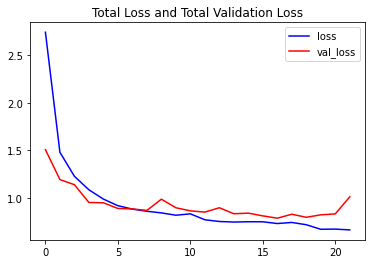

In [48]:
# Construct a range object 
epochs = range(len(history.history["loss"]))
# Plot the Graph.
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
# Add title 
plt.title("Total Loss and Total Validation Loss")
# Add legend 
plt.legend()

##### **<font style="color:rgb(134,19,348)">Total Accuracy and Total Validation Accuracy</font>**

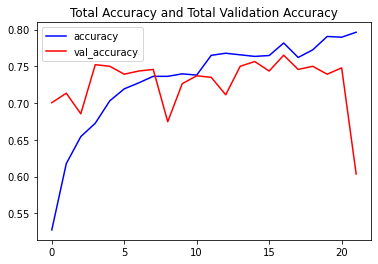

In [49]:
# Construct a range object 
epochs = range(len(history.history["accuracy"]))
# Plot the Graph.
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
# Add title 
plt.title("Total Accuracy and Total Validation Accuracy")
# Add legend 
plt.legend()

## **<font style="color:rgb(134,19,348)">Step 4: Test the model**

I create the function `predict_on_image` that will preprocess the given image whose path is passed to it as argument and return the age class.

In [93]:
def predict_on_image(img_path):
    
    #Preprocess image 
    preprocessed_img=image_preprocessing(img_path)

    #Reshape
    reshaped_img=np.reshape(preprocessed_img,(1,img_height,img_width,3))
    
    # Passing the img to the model and get the predicted probabilities
    predicted_labels_probabilities=model.predict(reshaped_img)
    # Get the class index with highest probability.
    class_index=np.argmax(predicted_labels_probabilities)
    #Get age class 
    age_class=str(class_index*25)+"-"+str((class_index+1)*25-1)
    
    return age_class
    
    
    

I will iterate through each and every image in `sample images` folder and put the predicted age range on each image

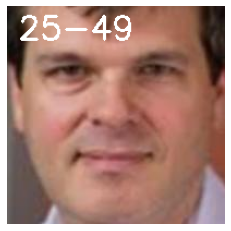

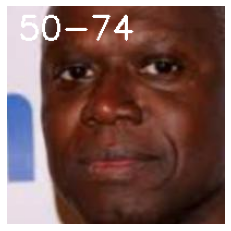

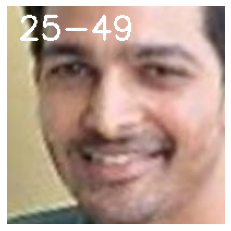

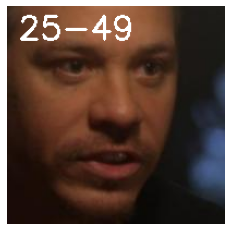

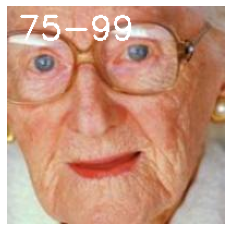

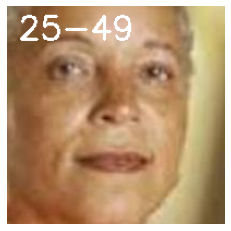

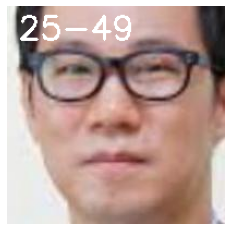

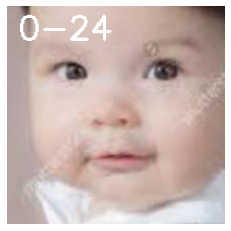

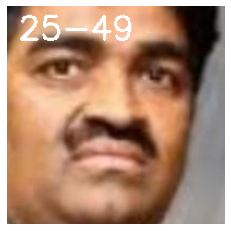

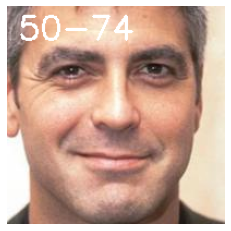

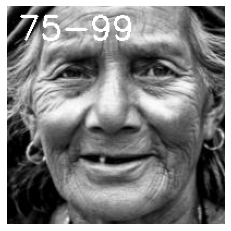

In [95]:
#path of sample image dataset
sample_dir="/Users/kumara/Desktop/machine learning /deep learning projects/supervised/Age detecting flask app using CNN/new/testing"

#all sample image names
sample_img_names=os.listdir(sample_dir)


for counter,sample_img_name in enumerate(sample_img_names):
    
    #DS_Store mac system file is created to store metadata of folder.
    if sample_img_name!='.DS_Store':

        #path of the selected image
        sample_path=os.path.join(sample_dir,sample_img_name)

        
        #get the prediction
        predicted_age_class=predict_on_image(sample_path)
        
        #Read sample image in BGR format
        sample_img_bgr=cv2.imread(sample_path)
        
        #Convert it into RGB format
        sample_img_rgb= cv2.cvtColor(sample_img_bgr ,cv2.COLOR_BGR2RGB)
        
        #Write predicted age class on top of the image
        cv2.putText(sample_img_rgb, predicted_age_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
        #Display the selected image
        plt.imshow(sample_img_rgb)
        plt.axis('off')
        plt.show()
        
